In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import KarateClub

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

$H = \sigma(\tilde{A}XW)$ <br>
$\tilde{A} = \hat{A}D^{-1} = (A+I)D^{-1}$

In [2]:
class GCNLayer(nn.Module):

    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.w = nn.Linear(in_features=in_features, out_features=out_features, bias=False) 

    def forward(self, A, X):
        h = self.w(X)
        h = A @ h 
        return h
    

class GCNModel(nn.Module):

    def __init__(self, in_features, hidden_dim, num_classes):
        super(GCNModel, self).__init__()
        self.l1 = GCNLayer(in_features, hidden_dim)
        self.l2 = GCNLayer(hidden_dim, num_classes)

    def forward(self, A, X):
        H = self.l1(A, X)
        H = F.relu(H)
        H = self.l2(A, H)
        return H 

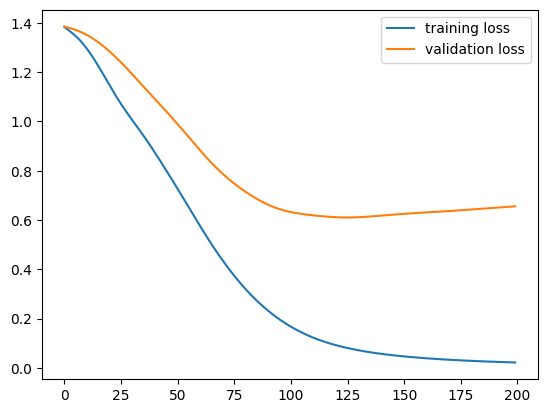

In [3]:
dataset = KarateClub()
data = dataset[0]
x = data.x 
y = data.y
train_mask = data.train_mask
edge_index = data.edge_index
num_nodes = data.y.shape[0]
num_edges = edge_index.shape[1]

A = torch.sparse_coo_tensor(edge_index, torch.ones(num_edges), (num_nodes, num_nodes))
A = A.to_dense()
A += torch.eye(num_nodes)
D_inv = torch.diag(1 / A.sum(0))
A = A @ D_inv

model = GCNModel(in_features=num_nodes, hidden_dim=8, num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
valid_losses = []
for epoch in range(200):
    optimizer.zero_grad()
    output = model(A, x)
    train_loss = criterion(output[train_mask], y[train_mask])
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    with torch.no_grad():
        valid_loss = criterion(output[~train_mask], y[~train_mask])
        valid_losses.append(valid_loss)


plt.plot(train_losses, label='training loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

In [4]:
with torch.no_grad():
    X_embedding = model.l1(A, x)

In [5]:
p = 3
X_2d = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=p, n_iter=1000).fit_transform(X_embedding)

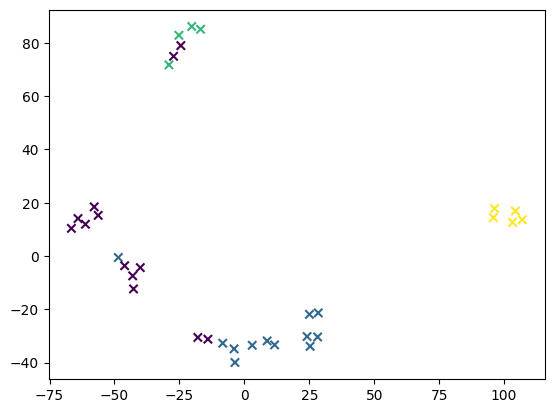

In [6]:
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, marker='x')

In [7]:
import networkx as nx

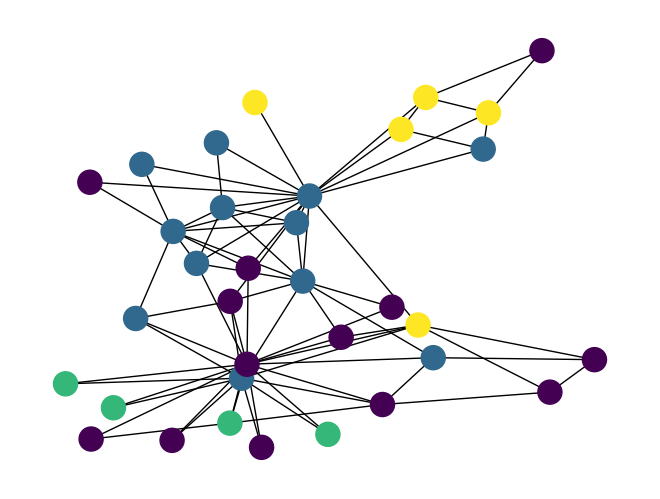

In [8]:
G = nx.Graph()
G.add_edges_from(edge_index.T.numpy())
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=y)